In [ ]:
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [ ]:
data = pd.read_csv('/content/AAPL_5min_60days.csv')
data.head()

,Price,Close,High,Low,Open,Volume
0,2024-11-25 14:30:00+00:00,232.320007,232.580002,231.419998,231.839996,3645145
1,2024-11-25 14:35:00+00:00,232.683899,232.820007,232.199997,232.315002,1107931
2,2024-11-25 14:40:00+00:00,233.139999,233.149994,232.419998,232.679993,984043
3,2024-11-25 14:45:00+00:00,232.690002,233.184998,232.625793,232.940002,549490
4,2024-11-25 14:50:00+00:00,232.401993,232.759995,231.990005,232.695007,676341


In [ ]:
df.rename(columns={"Price": "Datetime"}, inplace=True)
df

,Open,High,Low,Close,Volume,hour_sin,hour_cos,minute_sin,minute_cos
8,232.029999,232.159897,231.830002,231.990005,490636,-0.707107,-0.707107,8.660254e-01,5.000000e-01
9,231.979996,232.029999,231.619904,231.710007,352199,-0.707107,-0.707107,1.000000e+00,2.832769e-16
10,231.714996,232.024994,231.695007,232.020004,304686,-0.707107,-0.707107,8.660254e-01,-5.000000e-01
11,232.020004,232.110001,231.731293,232.000000,259785,-0.707107,-0.707107,5.000000e-01,-8.660254e-01
12,231.979996,232.190002,231.729996,231.869995,531767,-0.707107,-0.707107,5.665539e-16,-1.000000e+00
...,...,...,...,...,...,...,...,...,...
4603,247.589996,247.720001,247.470001,247.550003,273384,-0.866025,0.500000,-5.000000e-01,-8.660254e-01
4604,247.559998,247.559998,247.300003,247.479996,398599,-0.866025,0.500000,-8.660254e-01,-5.000000e-01
4605,247.470001,247.789993,247.286804,247.750000,354919,-0.866025,0.500000,-1.000000e+00,-1.836970e-16
4606,247.759995,247.759995,247.029999,247.279999,807079,-0.866025,0.500000,-8.660254e-01,5.000000e-01


In [ ]:

df = data.copy()


df.rename(columns={"Price": "Datetime"}, inplace=True)
df = df[["Datetime", "Open", "High", "Low", "Close", "Volume"]]

# Convert 'Datetime' column to datetime type
df["Datetime"] = pd.to_datetime(df["Datetime"])


# Extract hour and minute from the datetime column
df["hour"] = df["Datetime"].dt.hour
df["minute"] = df["Datetime"].dt.minute

# Apply cyclical encoding to the hour (24-hour cycle)
df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)

# Apply cyclical encoding to the minute (60-minute cycle)
df["minute_sin"] = np.sin(2 * np.pi * df["minute"] / 60)
df["minute_cos"] = np.cos(2 * np.pi * df["minute"] / 60)

# Drop the original datetime and raw time features if not needed for prediction
df.drop(columns=["Datetime", "hour", "minute"], inplace=True)


n = 5  # Rolling window length

# Price Features
# (1) Instantaneous Return: (Close - Open) / Open
df["instant_return"] = (df["Close"] - df["Open"]) / df["Open"]

# (2) Price Volatility: (High - Low) / Open
df["price_volatility"] = (df["High"] - df["Low"]) / df["Open"]

# (3) Price Momentum: (Close - Close.shift(n)) / Close.shift(n)
df["price_momentum_n"] = (df["Close"] - df["Close"].shift(n)) / df["Close"].shift(n)

# (4) Deviation from Moving Average: (Close / MA(Close, n)) - 1
df["ma_diff_n"] = df["Close"] / df["Close"].rolling(n).mean() - 1

# Volume Features
# (5) Volume Change Ratio: (Volume / Volume.rolling(n).mean()) - 1
df["volume_change_n"] = df["Volume"] / df["Volume"].rolling(n).mean() - 1

# (6) Volume Momentum: Volume - Volume.shift(n)
df["volume_momentum_n"] = df["Volume"] - df["Volume"].shift(n)

# Combined Price-Volume Features
# (7) Volume Weighted Return: instant_return * (Volume / Volume.rolling(n).mean())
df["volume_weighted_return"] = df["instant_return"] * (df["Volume"] / df["Volume"].rolling(n).mean())

# (8) VWAP over n periods: rolling sum(Close * Volume) / rolling sum(Volume)
df["vwap_n"] = (df["Close"] * df["Volume"]).rolling(n).sum() / df["Volume"].rolling(n).sum()

# Price-Volume Correlation Features
# (9) Price Return Percentage: percentage change in Close prices
df["return_pct"] = df["Close"].pct_change()
# (10) Volume Percentage Change: percentage change in Volume
df["volume_pct"] = df["Volume"].pct_change()
# (11) Price-Volume Correlation over n periods
df["price_volume_corr_n"] = df["return_pct"].rolling(n).corr(df["volume_pct"])

# (12) Ratio of Volume Volatility to Price Volatility:
df["volume_volatility_n"] = df["Volume"].rolling(n).std()
df["price_volatility_n"] = df["Close"].rolling(n).std()
df["vol_ratio_n"] = df["volume_volatility_n"] / df["price_volatility_n"]

# Ranking and Lag Features
# (13) Ranking of Instantaneous Return within a rolling window of n periods
df["rank_return_n"] = df["instant_return"].rolling(n).apply(
    lambda x: x.rank(method="first").iloc[-1] if len(x.dropna()) == n else np.nan
)

# (14) Ranking of Volume Change Ratio within a rolling window of n periods
df["rank_vol_chg_n"] = df["volume_change_n"].rolling(n).apply(
    lambda x: x.rank(method="first").iloc[-1] if len(x.dropna()) == n else np.nan
)

# (15) Difference between the two rankings
df["rank_diff_n"] = df["rank_return_n"] - df["rank_vol_chg_n"]

# (16) Lag Features: previous period's instant_return and Volume
df["lag_return_1"] = df["instant_return"].shift(1)
df["lag_volume_1"] = df["Volume"].shift(1)


# Drop rows with NaN values generated by rolling or lag operations
df.dropna(inplace=True)

# Display a sample of the constructed features
selected_columns = [
    "instant_return", "price_volatility", "price_momentum_n", "ma_diff_n",
    "volume_change_n", "volume_momentum_n", "volume_weighted_return", "vwap_n",
    "price_volume_corr_n", "vol_ratio_n", "rank_return_n", "rank_vol_chg_n",
    "rank_diff_n", "lag_return_1", "lag_volume_1", "hour_sin", "hour_cos",
    "minute_sin", "minute_cos"
]
print("Sample of constructed features:")
print(df[selected_columns].head())

Sample of constructed features:
    instant_return  price_volatility  price_momentum_n  ma_diff_n  \
8        -0.000172          0.001422         -0.003008  -0.001018   
9        -0.001164          0.001768         -0.002978  -0.001629   
10        0.001316          0.001424         -0.002494   0.000207   
11       -0.000086          0.001632         -0.000560   0.000233   
12       -0.000474          0.001983         -0.000603  -0.000207   

    volume_change_n  volume_momentum_n  volume_weighted_return      vwap_n  \
8         -0.071626           -58854.0               -0.000160  232.244637   
9         -0.240395          -324142.0               -0.000884  232.117509   
10        -0.274987          -217059.0                0.000954  231.983565   
11        -0.311675          -214164.0               -0.000059  231.949049   
12         0.371189            51991.0               -0.000650  231.912290   

    price_volume_corr_n    vol_ratio_n  rank_return_n  rank_vol_chg_n  \
8          

In [ ]:
df

,Open,High,Low,Close,Volume,hour_sin,hour_cos,minute_sin,minute_cos,instant_return,...,volume_pct,price_volume_corr_n,volume_volatility_n,price_volatility_n,vol_ratio_n,rank_return_n,rank_vol_chg_n,rank_diff_n,lag_return_1,lag_volume_1
8,232.029999,232.159897,231.830002,231.990005,490636,-0.707107,-0.707107,8.660254e-01,5.000000e-01,-0.000172,...,0.022636,-0.454598,8.468488e+04,0.265716,3.187044e+05,4.0,5.0,-1.0,-0.000474,479776.0
9,231.979996,232.029999,231.619904,231.710007,352199,-0.707107,-0.707107,1.000000e+00,2.832769e-16,-0.001164,...,-0.282158,-0.025561,6.498214e+04,0.324993,1.999495e+05,2.0,3.0,-1.0,-0.000172,490636.0
10,231.714996,232.024994,231.695007,232.020004,304686,-0.707107,-0.707107,8.660254e-01,-5.000000e-01,0.001316,...,-0.134904,0.160323,8.568415e+04,0.156268,5.483168e+05,5.0,1.0,4.0,-0.001164,352199.0
11,232.020004,232.110001,231.731293,232.000000,259785,-0.707107,-0.707107,5.000000e-01,-8.660254e-01,-0.000086,...,-0.147368,0.223409,1.037532e+05,0.132398,7.836447e+05,4.0,1.0,3.0,0.001316,304686.0
12,231.979996,232.190002,231.729996,231.869995,531767,-0.707107,-0.707107,5.665539e-16,-1.000000e+00,-0.000474,...,1.046950,-0.175746,1.181788e+05,0.130268,9.071954e+05,2.0,5.0,-3.0,-0.000086,259785.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4603,247.589996,247.720001,247.470001,247.550003,273384,-0.866025,0.500000,-5.000000e-01,-8.660254e-01,-0.000162,...,-0.195501,-0.734470,3.666295e+04,0.129111,2.839646e+05,4.0,1.0,3.0,0.000061,339819.0
4604,247.559998,247.559998,247.300003,247.479996,398599,-0.866025,0.500000,-8.660254e-01,-5.000000e-01,-0.000323,...,0.458019,-0.413723,4.918805e+04,0.118956,4.134986e+05,2.0,4.0,-2.0,-0.000162,273384.0
4605,247.470001,247.789993,247.286804,247.750000,354919,-0.866025,0.500000,-1.000000e+00,-1.836970e-16,0.001131,...,-0.109584,-0.455011,4.691390e+04,0.099500,4.714980e+05,5.0,2.0,3.0,-0.000323,398599.0
4606,247.759995,247.759995,247.029999,247.279999,807079,-0.866025,0.500000,-8.660254e-01,5.000000e-01,-0.001937,...,1.273981,-0.854737,2.129317e+05,0.173293,1.228741e+06,1.0,5.0,-4.0,0.001131,354919.0


In [ ]:



df['target'] = df['instant_return'].shift(-1) * 100
df = df.dropna().reset_index(drop=True)

features = df.drop(columns=['target'])
target = df['target']

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)


def create_sequences(X, y, seq_length):
    Xs, ys = [], []
    for i in range(len(X) - seq_length):
        Xs.append(X[i:(i+seq_length)])
        ys.append(y[i+seq_length])
    return np.array(Xs), np.array(ys)

seq_length = 10
X_seq, y_seq = create_sequences(features_scaled, target.values, seq_length)


split_index = int(len(X_seq) * 0.8)
X_train, X_val = X_seq[:split_index], X_seq[split_index:]
y_train, y_val = y_seq[:split_index], y_seq[split_index:]


class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        #  tensor  float32
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

batch_size = 32
train_dataset = TimeSeriesDataset(X_train, y_train)
val_dataset = TimeSeriesDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size1=64, hidden_size2=32, dropout=0.2):
        super(GRUModel, self).__init__()
        self.gru1 = nn.GRU(input_size, hidden_size1, batch_first=True)
        self.dropout1 = nn.Dropout(dropout)
        self.gru2 = nn.GRU(hidden_size1, hidden_size2, batch_first=True)
        self.dropout2 = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size2, 1)

    def forward(self, x):
        # (batch_size, seq_length, input_size)
        out, _ = self.gru1(x)       # shape: (batch_size, seq_length, hidden_size1)
        out = self.dropout1(out)
        out, _ = self.gru2(out)     # shape: (batch_size, seq_length, hidden_size2)
        out = self.dropout2(out)

        out = out[:, -1, :]         # shape: (batch_size, hidden_size2)
        out = self.fc(out)
        return out

input_size = X_train.shape[2]
model = GRUModel(input_size)
print(model)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    train_losses = []
    for batch_X, batch_y in train_loader:
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)

        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())


    model.eval()
    val_losses = []
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            val_losses.append(loss.item())

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {np.mean(train_losses):.6f}, Val Loss: {np.mean(val_losses):.6f}")

GRUModel(
  (gru1): GRU(28, 64, batch_first=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (gru2): GRU(64, 32, batch_first=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)
Epoch 1/100, Train Loss: 0.023299, Val Loss: 0.019962
Epoch 2/100, Train Loss: 0.020544, Val Loss: 0.019918
Epoch 3/100, Train Loss: 0.019560, Val Loss: 0.019049
Epoch 4/100, Train Loss: 0.019204, Val Loss: 0.018802
Epoch 5/100, Train Loss: 0.018988, Val Loss: 0.018825
Epoch 6/100, Train Loss: 0.018730, Val Loss: 0.018790
Epoch 7/100, Train Loss: 0.018670, Val Loss: 0.018890
Epoch 8/100, Train Loss: 0.018724, Val Loss: 0.018872
Epoch 9/100, Train Loss: 0.018494, Val Loss: 0.018942
Epoch 10/100, Train Loss: 0.018368, Val Loss: 0.019109
Epoch 11/100, Train Loss: 0.018372, Val Loss: 0.018928
Epoch 12/100, Train Loss: 0.017993, Val Loss: 0.019158
Epoch 13/100, Train Loss: 0.018057, Val Loss: 0.019213
Epoch 14/100, Train Loss: 0.017901, Val Loss: 0.019556
E

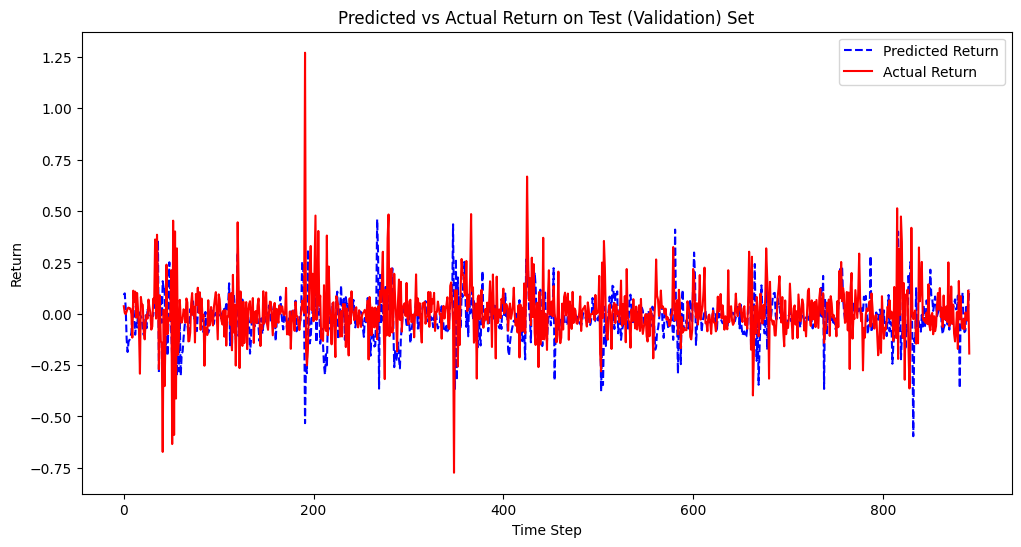

In [ ]:
model.eval()
all_preds = []
all_actuals = []

with torch.no_grad():
    for batch_X, batch_y in val_loader:
        batch_X = batch_X.to(device)
        outputs = model(batch_X)
        all_preds.extend(outputs.cpu().numpy().flatten())
        all_actuals.extend(batch_y.cpu().numpy().flatten())

all_preds = np.array(all_preds)
all_actuals = np.array(all_actuals)

plt.figure(figsize=(12, 6))
plt.plot(all_preds, label='Predicted Return', linestyle='--', color='blue')
plt.plot(all_actuals, label='Actual Return', color='red')
plt.xlabel('Time Step')
plt.ylabel('Return')
plt.title('Predicted vs Actual Return on Test (Validation) Set')
plt.legend()
plt.show()

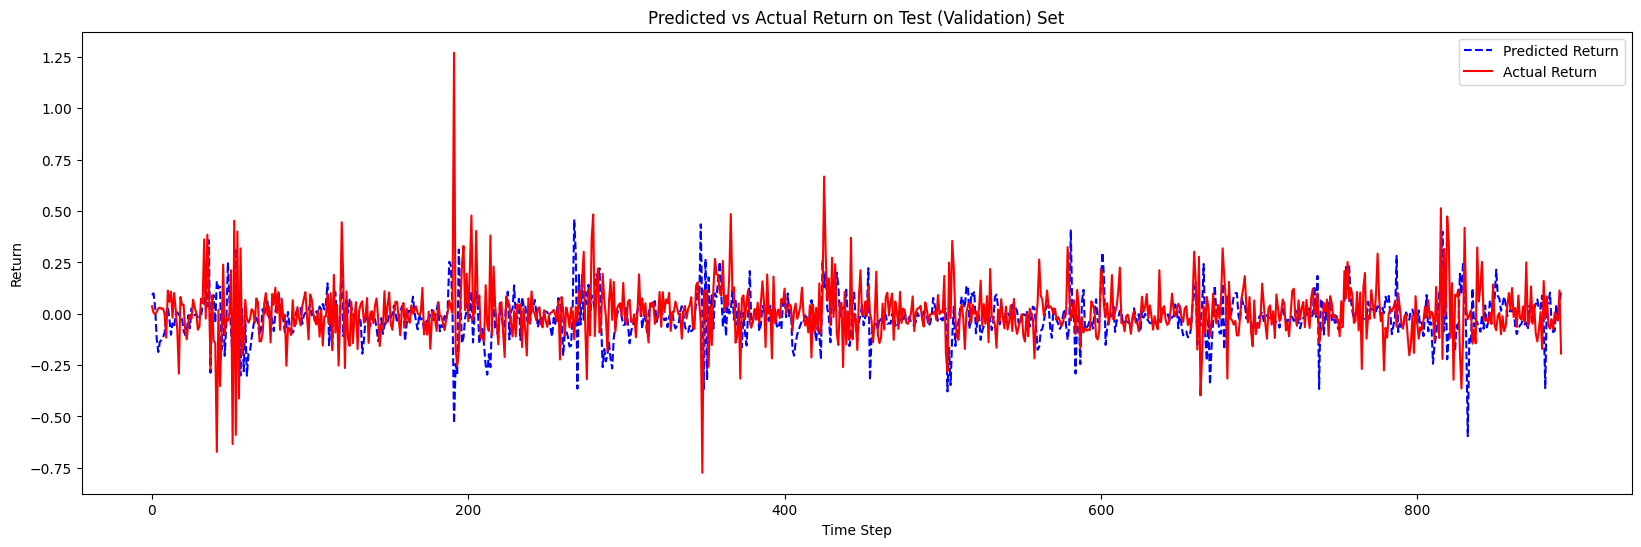

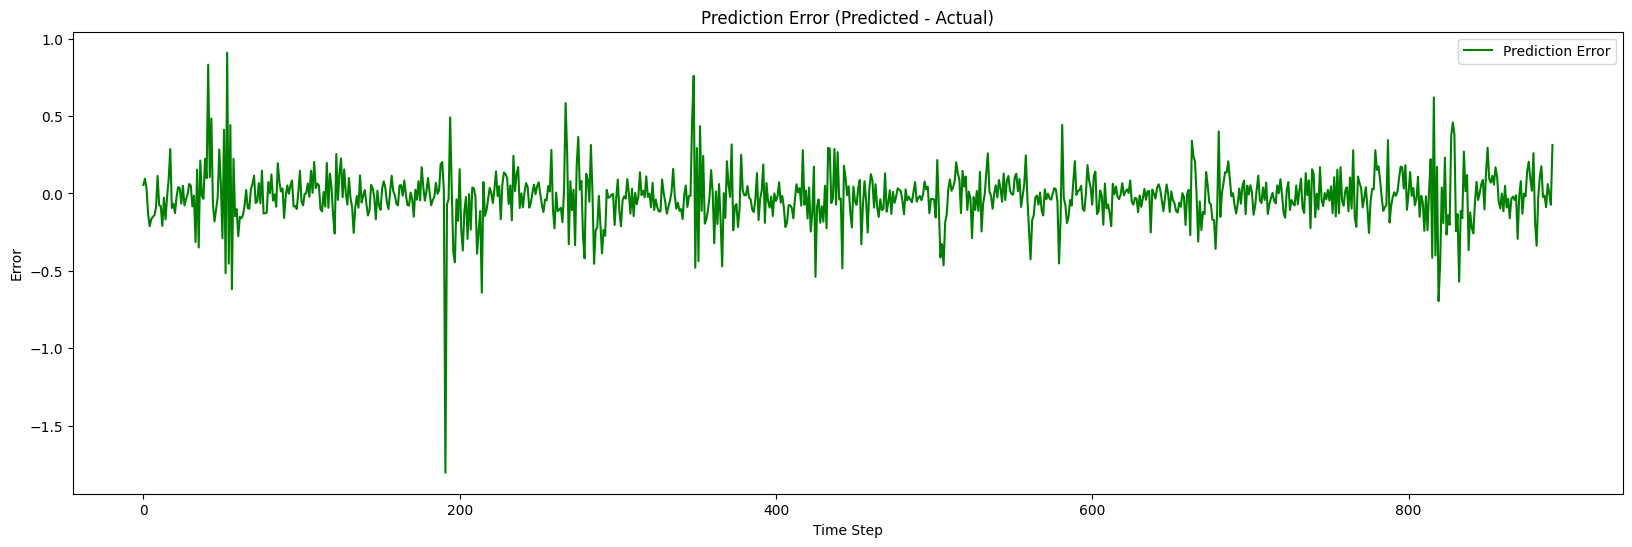

In [ ]:

plt.figure(figsize=(20, 6))
plt.plot(all_preds, label='Predicted Return', linestyle='--', color='blue')
plt.plot(all_actuals, label='Actual Return', color='red')
plt.xlabel('Time Step')
plt.ylabel('Return')
plt.title('Predicted vs Actual Return on Test (Validation) Set')
plt.legend()
plt.show()

prediction_error = all_preds - all_actuals

plt.figure(figsize=(20, 6))
plt.plot(prediction_error, label='Prediction Error', color='green')
plt.xlabel('Time Step')
plt.ylabel('Error')
plt.title('Prediction Error (Predicted - Actual)')
plt.legend()
plt.show()